First we will download the MNIST dataset from Keras and visualize it using matplotlib and OpenCV.


In [1]:
import keras
import numpy as np
from matplotlib import pyplot
import cv2
print("keras - " + keras.__version__)
print("OpenCV - " + cv2.__version__)

keras - 2.15.0
OpenCV - 4.9.0


In [2]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [3]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


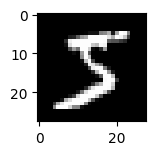

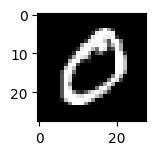

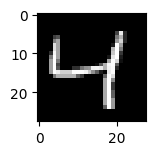

In [4]:
# Visualize images with matplotlib
for i in range(3):
   pyplot.subplot(330 + 1 + i)
   pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
   pyplot.show()

In [12]:
# Define function to visulize images with OpenCV
def showImageCV(title, image):
   cv2.namedWindow(title, cv2.WINDOW_NORMAL)
   cv2.imshow(title, image)
   cv2.resizeWindow(title, 800, 800)
   cv2.waitKey(0)
   cv2.destroyWindow(title)
   cv2.waitKey(1)

In [39]:
def showImage(title, image):
    pyplot.title(title)
    pyplot.imshow(image, cmap=pyplot.get_cmap('gray'))

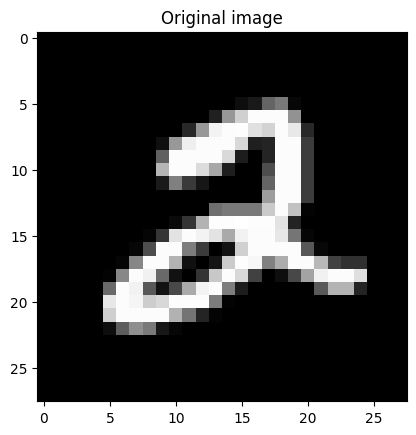

In [67]:
# Visialize sample image with OpenCV
pixels = np.array(train_X[5], dtype='uint8')
img = pixels.reshape((28,28))
showImage("Original image", img)

### Thresholding
Lets do a simple gradient to visualize the image in grayscale using thresholding:

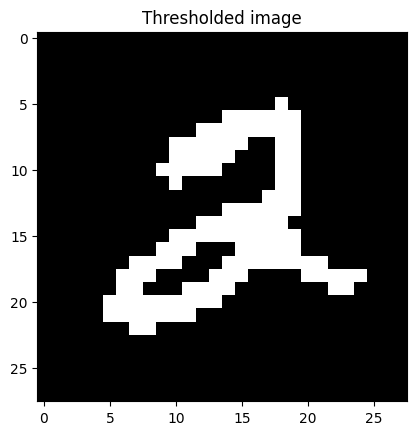

In [74]:
# Threshold using OTSU
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
showImage("Thresholded image", thresh)

### Opening
Now we perform an opening operation, which is an erosion followed up by a dilation of the image to remove any noise. With erosion we blur away the boundaries of the foreground. With dilation we do the exact oposite, adding pixels to the boundaries of the image.

As the MNIST dataset is already black and white images without noise we should expect the output to be almost the same, if not worse due to the erosion.

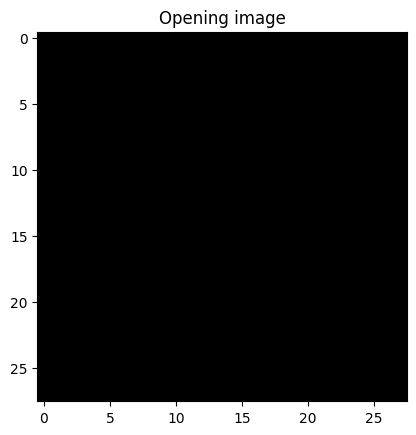

In [75]:
# noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
showImage("Opening image", opening)

As we can see, performing opening in images with such a small resolution (28x28) erodes the entire figure away, so we will skip noise removal operations going forward.

### Background, foreground and unkown identification
Now we will identify the sure background and sure foreground regions on the image, as an input to the watershed algorithm.

For the sure background we apply a dilation operation to the image where the noise has been removed. As we saw before the image outputed by the thresholding is already free of noise, and any denoising operation on such small images is likely to erode them more than denoise them. So we apply a dilate operation with the same kernel as before to the thresholded image.

The kernel used is:

\begin{equation}
\begin{pmatrix}
  1       1       1  \\
  1       1       1  \\
  1       1       1  \\
\end{pmatrix}
\end{equation}


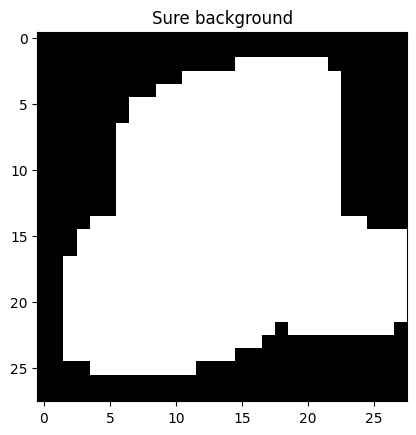

In [76]:
# sure background area
sure_bg = cv2.dilate(thresh, kernel, iterations=3)
showImage("Sure background", sure_bg)

For the sure foreground we apply distance transform to identify regions far from the background that are likely to be foreground.

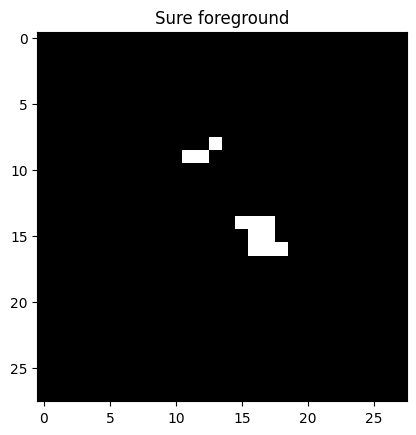

In [77]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
showImage("Sure foreground", sure_fg)

Finally we substract the sure foreground from the sure background to obtain the unkown region that could potentially be either background or foreground.

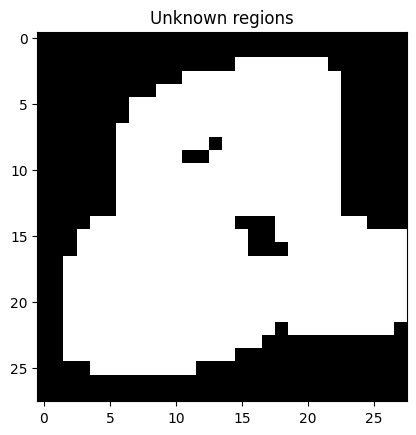

In [78]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
showImage("Unknown regions", unknown)


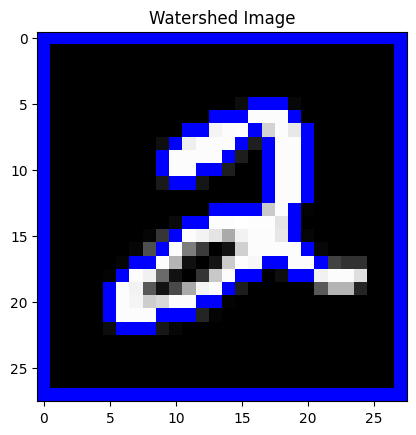

In [79]:
cv_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Marker labelling
# Connected Components determines the connectivity of blob-like regions in a binary image.
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(cv_img,markers)
cv_img[markers == -1] = [0,0,255]

showImage("Watershed Image", cv_img)